<a href="https://colab.research.google.com/github/ashikaede/CCADMACL_EXERCISES/blob/main/Colocado_Exercise6_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 6

Netflix is the world's largest online streaming service provider, with over 220 million subscribers. It is crucial that they effectively cluster the shows that are hosted on their platform in order to enhance the user experience, thereby preventing subscribers from ending their subscription.

We will be able to understand the shows that are similar to and different from one another by creating clusters, which may be leveraged to offer the consumers personalized show suggestions depending on their preferences.

## Instructions

1. Your task is to group the Netflix shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other. Use Principal Component Analysis and any Clustering Algorithm.

2. After creating the clusters, profile each cluster that you have created.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [65]:
df = pd.read_csv("https://github.com/robitussin/CCADMACL_EXERCISES/blob/353cd84703a9e313ee7ecf37fb97a067aa81ddbc/netflix.csv?raw=true")

In [66]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


##Data Cleaning and Feature Engineering

In [77]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Strip spaces from all columns
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Drop unnecessary columns
df_cleaned = df.drop(columns=["show_id", "title", "description", "director", "cast", "country"])

# Convert 'date_added' to datetime and extract features
df_cleaned["date_added"] = pd.to_datetime(df_cleaned["date_added"], format='%B %d, %Y', errors='coerce')
df_cleaned["year_added"] = df_cleaned["date_added"].dt.year
df_cleaned["month_added"] = df_cleaned["date_added"].dt.month
df_cleaned["season_added"] = df_cleaned["month_added"].apply(lambda x: "Winter" if x in [12, 1, 2]
                                                               else "Spring" if x in [3, 4, 5]
                                                               else "Summer" if x in [6, 7, 8]
                                                               else "Fall")
df_cleaned.drop(columns=["date_added"], inplace=True)

# Process 'duration' column: Convert to numerical
df_cleaned["duration"] = df_cleaned["duration"].str.extract("(\d+)").astype(float)

# Encode categorical variables
df_cleaned["type"] = df_cleaned["type"].map({"Movie": 0, "TV Show": 1})

# One-hot encode 'rating'
df_cleaned = pd.get_dummies(df_cleaned, columns=["rating"], dummy_na=True)

# One-hot encode 'listed_in' (genre categories) and add additional features
df_cleaned["listed_in"] = df_cleaned["listed_in"].str.split(", ")
genres = df_cleaned["listed_in"].explode().unique()
for genre in genres:
    df_cleaned[genre] = df_cleaned["listed_in"].apply(lambda x: 1 if genre in x else 0)
df_cleaned["num_genres"] = df_cleaned["listed_in"].apply(lambda x: len(x))
df_cleaned["primary_genre"] = df_cleaned["listed_in"].apply(lambda x: x[0] if isinstance(x, list) else "Unknown")
df_cleaned.drop(columns=["listed_in"], inplace=True)

# Handle missing values
df_cleaned.fillna(df_cleaned.mean(numeric_only=True), inplace=True)

# Normalize 'duration' to scale values between 0 and 1
scaler = MinMaxScaler()
df_cleaned["duration"] = scaler.fit_transform(df_cleaned[["duration"]])

# Remove duplicates
df_cleaned = df_cleaned.drop_duplicates()

df_cleaned = pd.get_dummies(df_cleaned, columns=["primary_genre"], drop_first=True)


# Display final cleaned dataset
from IPython.display import display
display(df_cleaned)
print("Final Cleaned Netflix Dataset")


<ipython-input-77-a973ffe24348>:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


,type,release_year,duration,year_added,month_added,season_added,rating_G,rating_NC-17,rating_NR,rating_PG,...,primary_genre_Sports Movies,primary_genre_Stand-Up Comedy,primary_genre_Stand-Up Comedy & Talk Shows,primary_genre_TV Action & Adventure,primary_genre_TV Comedies,primary_genre_TV Dramas,primary_genre_TV Horror,primary_genre_TV Sci-Fi & Fantasy,primary_genre_TV Shows,primary_genre_Thrillers
0,1,2020,0.009646,2020.0,8.0,Summer,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,2016,0.295820,2016.0,12.0,Winter,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,2011,0.247588,2018.0,12.0,Winter,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,2009,0.254019,2017.0,11.0,Fall,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,2008,0.392283,2020.0,1.0,Winter,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,0,2005,0.315113,2020.0,10.0,Fall,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7783,0,2015,0.353698,2019.0,3.0,Spring,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7784,0,2019,0.138264,2020.0,9.0,Fall,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7785,1,2019,0.000000,2020.0,10.0,Fall,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Final Cleaned Netflix Dataset


In [78]:
df_cleaned.head()


,type,release_year,duration,year_added,month_added,season_added,rating_G,rating_NC-17,rating_NR,rating_PG,...,primary_genre_Sports Movies,primary_genre_Stand-Up Comedy,primary_genre_Stand-Up Comedy & Talk Shows,primary_genre_TV Action & Adventure,primary_genre_TV Comedies,primary_genre_TV Dramas,primary_genre_TV Horror,primary_genre_TV Sci-Fi & Fantasy,primary_genre_TV Shows,primary_genre_Thrillers
0,1,2020,0.009646,2020.0,8.0,Summer,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,2016,0.295820,2016.0,12.0,Winter,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,2011,0.247588,2018.0,12.0,Winter,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,2009,0.254019,2017.0,11.0,Fall,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,2008,0.392283,2020.0,1.0,Winter,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


1. Apply dimensionality reduction using Principal Component Analysis
- Use the necessary number of principal components

In [80]:
# Drop any remaining categorical columns that aren't numerical
df_numeric = df_cleaned.drop(columns=['season_added'])  # Remove season if still categorical

# Standardize the dataset (mean = 0, variance = 1)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Apply PCA
pca = PCA()
pca.fit(df_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)



2. Create a scree plot for each principal component

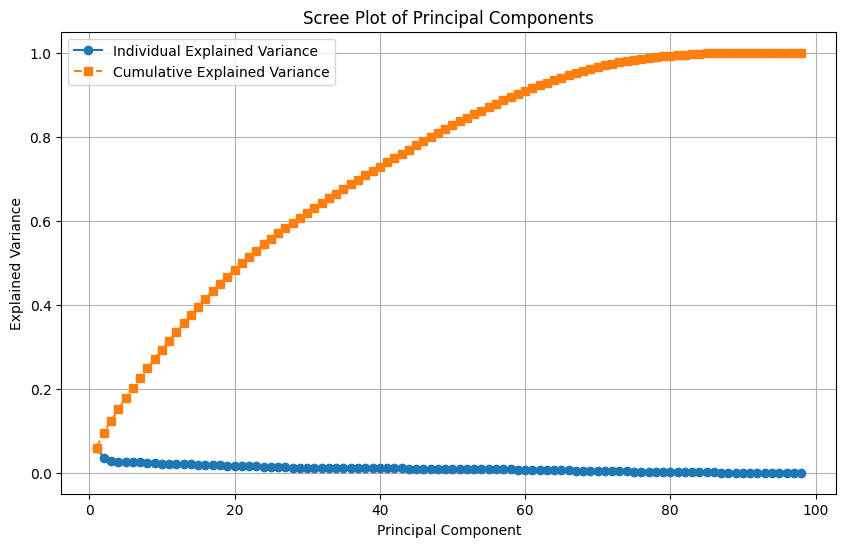

Optimal number of components: 59
PCA Transformed Data:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  4.308378  2.273667 -0.549491  0.855990 -2.385787  0.112145  0.032976   
1 -1.563349  0.928067  0.810352  0.917576  0.553467  0.341203 -0.694319   
2 -1.599723  0.092703  1.006744  1.853589  0.723939 -2.737161  1.553205   
3 -1.598494  0.428963 -0.618653  0.480533  0.269113 -1.178873  0.977596   
4 -1.950907 -0.036923 -0.086070  0.833931  0.583641 -0.320540  0.226234   

        PC8       PC9      PC10  ...      PC50      PC51      PC52      PC53  \
0 -2.165686  0.208806 -0.281623  ...  0.172811 -1.028289  1.246200 -1.596899   
1 -0.187512 -0.765272  0.379934  ...  0.053611  0.128228 -0.034320 -0.723777   
2  0.466707  4.613916 -0.623925  ... -0.009156  0.187746  0.831037 -0.082933   
3  0.129331  1.094866 -0.090302  ... -0.417393 -0.514224  0.210795  0.392930   
4  0.113285 -0.146329  0.221852  ...  0.101572 -0.303078 -0.688505 -0.494009   

       PC54  

In [81]:
# Scree plot to visualize component importance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='--', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Scree Plot of Principal Components')
plt.legend()
plt.grid()
plt.show()

# Determine the number of components to retain (90% variance)
n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Optimal number of components: {n_components}")

# Apply PCA with selected components
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_scaled)

# Convert PCA results into DataFrame
df_pca_df = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Display PCA transformed dataset
print("PCA Transformed Data:")
print(df_pca_df.head())

3. Use any clustering algorithm to create clusters

In [82]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300,
                  n_init = 10, random_state = 0)
kmeans.fit(df_pca_df)
labels = kmeans.labels_  # Cluster labels for each point
centroids = kmeans.cluster_centers_  # Cluster centroids

In [83]:
print("Cluster Centroids:\n", centroids)


Cluster Centroids:
 [[-1.49036104e+00 -8.99926804e-02  1.57897370e-01 -7.17158814e-02
  -1.34751268e-01 -6.28272097e-02 -3.02405811e-02 -9.13330950e-03
   6.36980418e-03  4.47149877e-02 -1.63930414e-02  5.78788300e-03
   1.44835896e-02  3.22026013e-02  6.94920836e-02 -2.91026188e-02
   2.23375085e-02  1.80806859e-02 -4.62898967e-02  9.53405410e-03
   6.10140454e-03  6.87742711e-03 -3.38187313e-02 -7.43719580e-03
   1.47853080e-02  6.49167754e-04 -4.80460786e-03  8.72604761e-03
  -9.21835391e-03 -8.01011057e-03 -2.94129484e-03  1.51193463e-02
   4.46933407e-03  1.75665240e-03  1.18694279e-02 -4.10752544e-03
   7.49982731e-03 -4.85139452e-03 -5.75135417e-03  4.22446413e-03
  -1.07411767e-02 -9.50351562e-04 -1.58177800e-03 -1.05890085e-02
  -7.38631308e-03  1.48423954e-03 -5.85977007e-04 -1.63895155e-02
  -4.66104589e-04 -2.77801250e-03 -1.15835617e-02 -5.94547505e-03
  -2.51031812e-03  3.25927555e-03  1.50067537e-03 -5.92096010e-03
   2.02545640e-02 -1.47022151e-02 -2.10082816e-02]
 [ 2.

4. Profile each cluster that you have generated based on your experiments

In [84]:
df_pca_df['Cluster'] = labels

In [85]:
cluster_summary = df_pca_df.groupby('Cluster').mean()
print(cluster_summary)

              PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Cluster                                                                         
0       -1.490361 -0.089993  0.157897 -0.071716 -0.134751 -0.062827 -0.030241   
1        2.951526 -4.187731 -2.039834  3.569044  1.600302  1.518916 -0.054536   
2        3.675711  1.130936 -0.029839 -0.536625  0.054720 -0.135379  0.098406   

              PC8       PC9      PC10  ...      PC50      PC51      PC52  \
Cluster                                ...                                 
0       -0.009133  0.006370  0.044715  ... -0.002778 -0.011584 -0.005945   
1       -0.461863 -0.073422 -0.518294  ...  0.086921 -0.078646  0.062296   
2        0.122451 -0.003050 -0.020810  ... -0.010100  0.049719  0.004145   

             PC53      PC54      PC55      PC56      PC57      PC58      PC59  
Cluster                                                                        
0       -0.002510  0.003259  0.001501 -0.005921  0.02

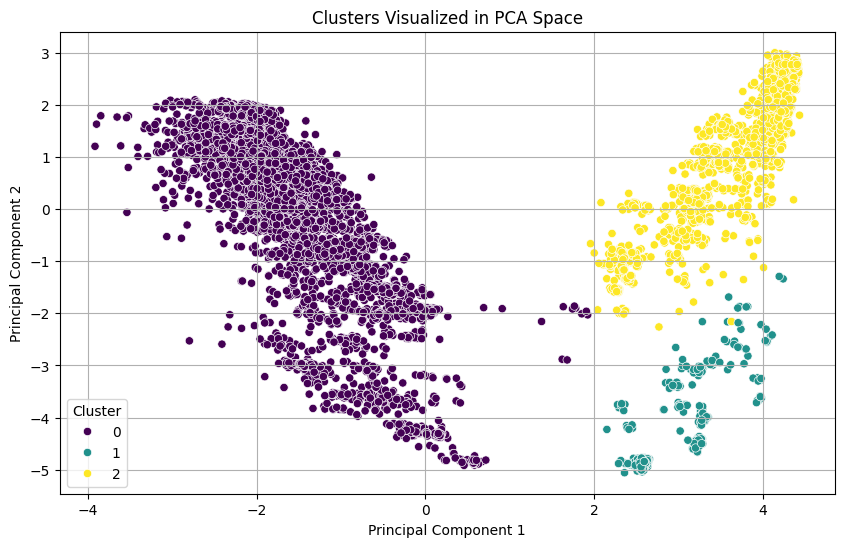

In [86]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca_df['PC1'], y=df_pca_df['PC2'], hue=df_pca_df['Cluster'], palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters Visualized in PCA Space')
plt.legend(title='Cluster')
plt.grid()
plt.show()